In [1]:
cd ../deepsalience/

/Users/rabitt/Dropbox/MARL/repos/multif0/deepsalience


In [146]:
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import librosa
import mir_eval
import numpy as np

import keras
from keras.models import Model
from keras.layers import Dense, Input, Reshape, Lambda
from keras.layers.merge import Concatenate
from keras.layers.convolutional import Conv2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import os

import compute_training_data as C
import experiment_datasets
import evaluate
import core

In [327]:
def add_note(f, t, n_t, decay):
    X = np.zeros((360, 50, 6))
    Y = np.zeros((360, 50))
    
    Y[f, t: t + n_t] = 1
    
    k_vals = [0, 60, 90, 120, 140, 155]
    h_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
    for j in range(0, 6):
        f_j = f - k_vals[j]
        for k in range(0, 6): 
            fidx = f_j + k_vals[k]
            if fidx >= 0 and fidx < 360:
                X[fidx, t: t + n_t, j] = decay**h_vals[k]

    return X, Y


def mute_node(prob_true):
    return np.random.choice([True, False], p=[prob_true, 1.0 - prob_true])


def make_fake_data():
    noise_floor = np.random.uniform(0, 0.5)
    
    X = np.random.uniform(low=0.0, high=noise_floor, size=(360, 50, 6))
    
    # transients
    for i in range(np.random.choice(range(4))):
        t = np.random.choice(range(5, 45))
        w = np.random.choice(range(0, 3))
        X[:, t-w:t+w, :] += np.random.uniform(low=0.1, high=1.0, size=(360, 2*w, 6))
    
    
    Y_multif0 = np.zeros((360, 50))
    Y_mel = np.zeros((360, 50))
    Y_bass = np.zeros((360, 50))
    Y_piano = np.zeros((360, 50))

    freq_range = np.arange(360)
    freq_p = np.zeros(freq_range.shape)
    mel_freq_p = np.zeros(freq_range.shape)
    bass_freq_p = np.zeros(freq_range.shape)
    freq_p[::5] = 1
    freq_p[1::5] = 0.5
    freq_p[4::5] = 0.5
    freq_p[2::5] = 0.1
    freq_p[3::5] = 0.1
    mel_freq_p[:] = freq_p
    bass_freq_p[:] = freq_p
    mel_freq_p[100:300] += 2
    bass_freq_p[:80] +=2
    freq_p = freq_p/np.sum(freq_p)
    mel_freq_p = mel_freq_p/np.sum(mel_freq_p)
    bass_freq_p = bass_freq_p/np.sum(bass_freq_p)

    time_len = range(5, 50)
    
    # extra multif0 info
    for i in range(np.random.choice(range(10))):
        f = np.random.choice(freq_range, p=freq_p)
        n_t = np.random.choice(time_len)
        t = np.random.choice(range(50 - n_t))
        decay = np.random.uniform(0.2, 0.6)
        
        X_note, Y_note = add_note(f, t, n_t, decay)
        X += X_note
        Y_multif0 += Y_note
    
    # piano info
    for i in range(np.random.choice(range(5))):
        f = np.random.choice(freq_range, p=freq_p)
        n_t = np.random.choice(time_len)
        t = np.random.choice(range(50 - n_t))
        X_note, Y_note = add_note(f, t, n_t, 0.7)
        
        X += X_note
        Y_piano += Y_note
        Y_multif0 += Y_note
            
    # melody
    for i in range(np.random.choice(range(3))):
        f = np.random.choice(freq_range, p=mel_freq_p)
        n_t = np.random.choice(time_len)
        t = np.random.choice(range(50 - n_t))
        
        X_note, Y_note = add_note(f, t, n_t, 0.9)
        
        X += X_note
        Y_mel += Y_note
        Y_multif0 += Y_note
    
    # bass
    for i in range(np.random.choice(range(3))):
        f = np.random.choice(freq_range, p=bass_freq_p)
        n_t = np.random.choice(time_len)
        t = np.random.choice(range(50 - n_t))
        X_note, Y_note = add_note(f, t, n_t, 0.5)
        
        X += X_note
        Y_bass += Y_note
        Y_multif0 += Y_note
           
    X = X/np.max(X)
    Y_multif0[Y_multif0 > 0] = 1
    Y_mel[Y_mel > 0] = 1
    Y_bass[Y_bass > 0] = 1
    Y_piano[Y_piano > 0] = 1

    X = X[np.newaxis, :, :, :]
    Y_multif0 = Y_multif0[np.newaxis, :, :]
    Y_mel = Y_mel[np.newaxis, :, :]
    Y_bass = Y_bass[np.newaxis, :, :]
    Y_piano = Y_piano[np.newaxis, :, :]

#     weight_shape = Y_multif0[0].shape
    weight_shape = (1, )
    weights = {}

    if mute_node(0):#(0.5):
        weights['multif0'] = np.zeros(weight_shape)
    else:
        weights['multif0'] = np.ones(weight_shape)
    
    if mute_node(0):#(0.6):
        weights['melody'] = np.zeros(weight_shape)
    else:
        weights['melody'] = np.ones(weight_shape)
    
    if mute_node(0.3):#(0.3):
        weights['bass'] = np.zeros(weight_shape)
    else:
        weights['bass'] = np.ones(weight_shape)
    
    if mute_node(0):#(0.8):
        weights['piano'] = np.zeros(weight_shape)
    else:
        weights['piano'] = np.ones(weight_shape)


    return (X, {'multif0': Y_multif0, 'melody': Y_mel, 'bass': Y_bass, 'piano': Y_piano}, weights)

In [292]:
X, Y, w = make_fake_data()
Y_multif0 = Y['multif0'][0]
Y_mel = Y['melody'][0]
Y_bass = Y['bass'][0]
Y_piano = Y['piano'][0]

(-0.5, 49.5, -0.5, 359.5)

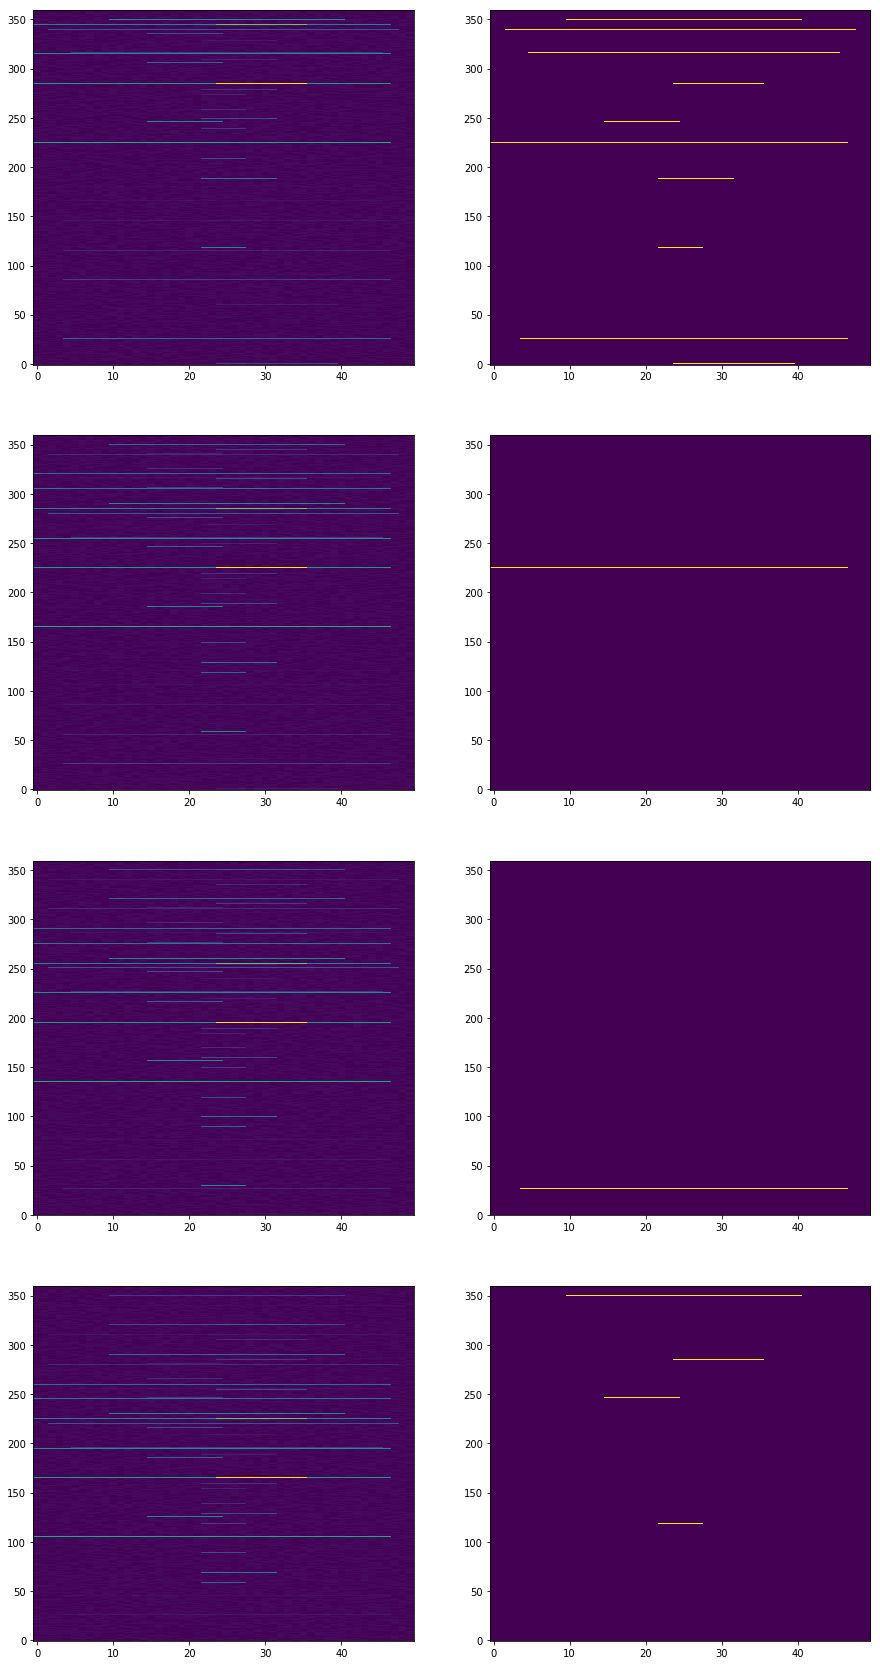

In [293]:
plt.figure(figsize=(15, 30))

plt.subplot(4, 2, 1)
plt.imshow(X[0, :, :, 0], origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 3)
plt.imshow(X[0, :, :, 1], origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 5)
plt.imshow(X[0, :, :, 2], origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 7)
plt.imshow(X[0, :, :, 3], origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 2)
plt.imshow(Y_multif0, origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 4)
plt.imshow(Y_mel, origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 6)
plt.imshow(Y_bass, origin='lower')
plt.axis('auto')

plt.subplot(4, 2, 8)
plt.imshow(Y_piano, origin='lower')
plt.axis('auto')

In [328]:
def data_generator():
    while True:
        yield make_fake_data()

In [329]:
input_shape = (None, None, 6)
inputs = Input(shape=input_shape)

y0 = BatchNormalization()(inputs)

y1_pitch = Conv2D(
    128, (5, 5), padding='same', activation='relu', name='pitch_layer1')(y0)
y1a_pitch = BatchNormalization()(y1_pitch)
y2_pitch = Conv2D(
    64, (5, 5), padding='same', activation='relu', name='pitch_layer2')(y1a_pitch)
y2a_pitch = BatchNormalization()(y2_pitch)

y1_timbre = Conv2D(
    128, (5, 5), padding='same', activation='relu', name='timbre_layer1')(y0)
y1a_timbre = BatchNormalization()(y1_timbre)
y2_timbre = Conv2D(
    64, (5, 5), padding='same', activation='relu', name='timbre_layer2')(y1a_timbre)
y2a_timbre = BatchNormalization()(y2_timbre)

y_multif0 = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='multif0_presqueeze')(y2a_pitch)
multif0 = Lambda(lambda x: K.squeeze(x, axis=3), name='multif0')(y_multif0)

y_concat = Concatenate()([y_multif0, y2a_timbre])


y_mel_feat = Conv2D(
    64, (5, 5), padding='same', activation='relu', name='melody_filters')(y_concat)
y_bass_feat = Conv2D(
    64, (5, 5), padding='same', activation='relu', name='bass_filters')(y_concat)
y_piano_feat = Conv2D(
    64, (5, 5), padding='same', activation='relu', name='piano_filters')(y_concat)

y_melody = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='melody_presqueeze')(y_mel_feat)
melody = Lambda(lambda x: K.squeeze(x, axis=3), name='melody')(y_melody)

y_bass = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='bass_presqueeze')(y_bass_feat)
bass = Lambda(lambda x: K.squeeze(x, axis=3), name='bass')(y_bass)

y_piano = Conv2D(
    1, (1, 1), padding='same', activation='sigmoid', name='piano_presqueeze')(y_piano_feat)
piano = Lambda(lambda x: K.squeeze(x, axis=3), name='piano')(y_piano)

model = Model(inputs=inputs, outputs=[multif0, melody, bass, piano])

In [ ]:
def bkld(y_true, y_pred):
    """Brian's KL Divergence implementation
    """
    y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return K.mean(K.mean(
        -1.0*y_true* K.log(y_pred) - (1.0 - y_true) * K.log(1.0 - y_pred),
        axis=-1), axis=-1)

In [330]:
model.compile(
    loss=bkld, #metrics=['mse', core.soft_binary_accuracy],
    optimizer='adam'#, sample_weight_mode={'multif0': None, 'melody': None, 'bass': None, 'piano': None}
)

In [333]:
train_generator = data_generator()
validation_generator = data_generator()

In [334]:
SAMPLES_PER_EPOCH = 50
NB_EPOCHS = 10
NB_VAL_SAMPLES = 50

history = model.fit_generator(
    train_generator, SAMPLES_PER_EPOCH, epochs=NB_EPOCHS, verbose=1,
    validation_data=validation_generator, validation_steps=NB_VAL_SAMPLES,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            "../outputs/multitask_test.pkl", save_best_only=True, verbose=1),
        keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1),
        keras.callbacks.EarlyStopping(patience=25, verbose=0)
    ]
)

Epoch 1/10
 4/50 [=>............................] - ETA: 151s - loss: nan - multif0_loss: 8.2988 - melody_loss: 0.4915 - bass_loss: nan - piano_loss: 0.4424      

KeyboardInterrupt: 

In [ ]:
evaluate.plot_metrics_epochs(history, plot_save_path)

In [197]:
model.load_weights("../outputs/multitask_test.pkl")

In [219]:
test = train_generator.next()
Y_pred = model.predict(test[0])
Y_true = test[1]

(-0.5, 49.5, -0.5, 359.5)

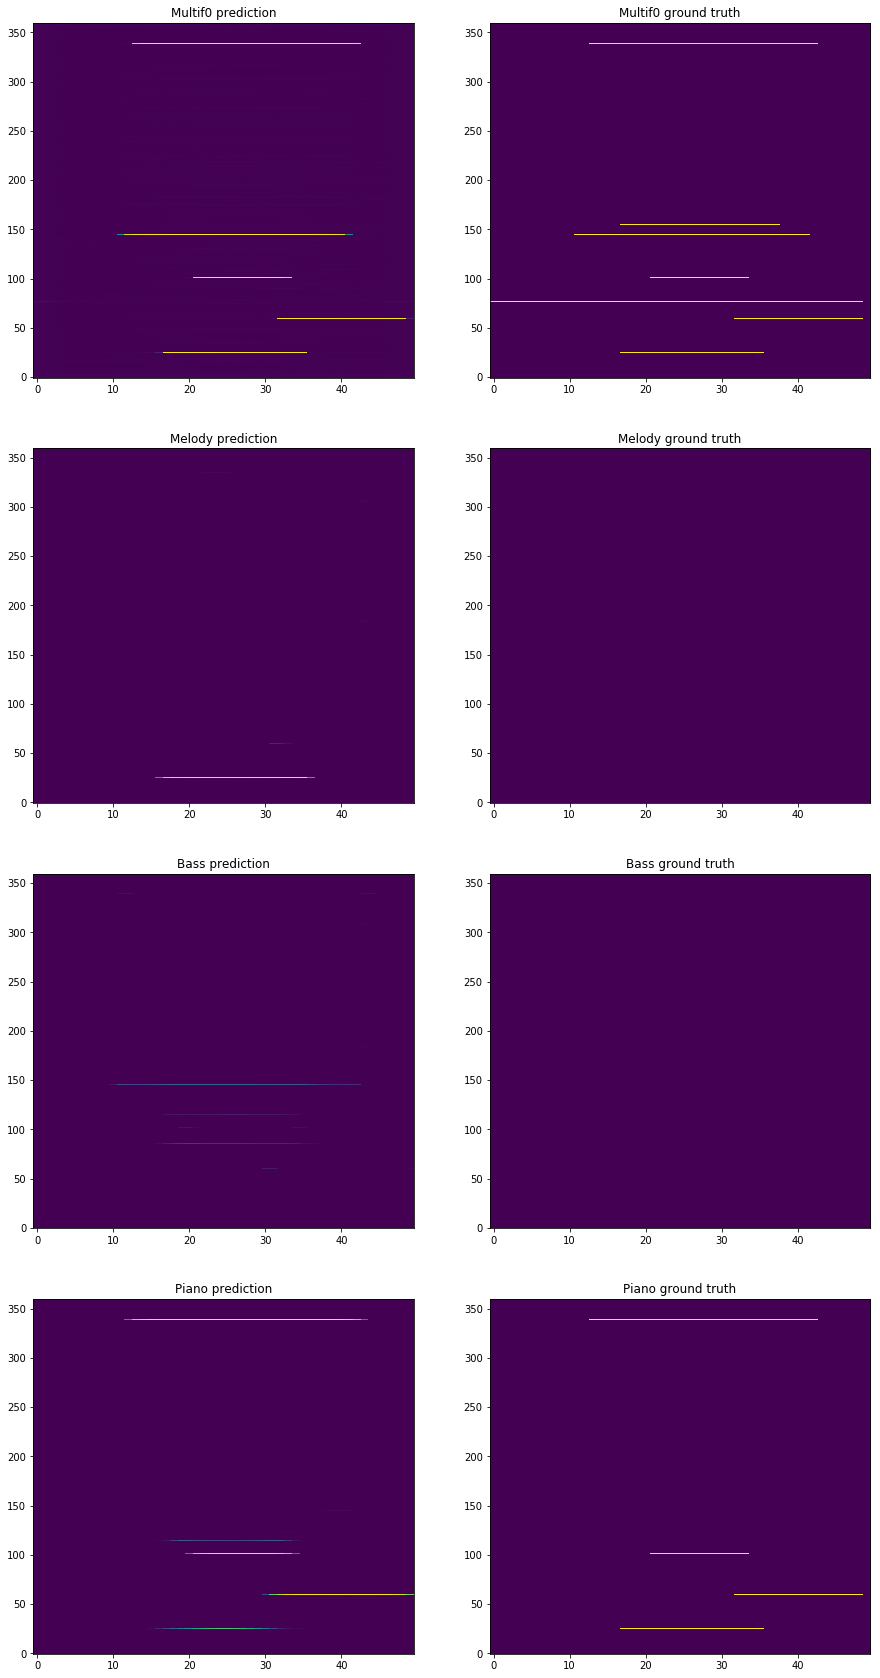

In [220]:
plt.figure(figsize=(15, 30))

plt.subplot(4, 2, 1)
plt.title("Multif0 prediction")
plt.imshow(Y_pred[0][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 2)
plt.title("Multif0 ground truth")
plt.imshow(Y_true['multif0'][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 3)
plt.title("Melody prediction")
plt.imshow(Y_pred[1][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 4)
plt.title("Melody ground truth")
plt.imshow(Y_true['melody'][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 5)
plt.title("Bass prediction")
plt.imshow(Y_pred[2][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 6)
plt.title("Bass ground truth")
plt.imshow(Y_true['bass'][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')


plt.subplot(4, 2, 7)
plt.title("Piano prediction")
plt.imshow(Y_pred[3][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')

plt.subplot(4, 2, 8)
plt.title("Piano ground truth")
plt.imshow(Y_true['piano'][0], origin='lower', vmin=0, vmax=1)
plt.axis('auto')


In [335]:
model.fit_generator?

In [336]:
model.compile?